# Recommender using MySQL Database / frequency of the chords

### This analysis focuses more on the frequency of the chords within a song
Meaning that probably songs that use more or less the same amount of chords will be clustered this can be confirmed with the bar plots

In [2]:
from ipynb.fs.full.DBMySQLConnection import getDB, connectDB
import pandas as pd
import plotly.express as px
import dask_ml.cluster
import copy
import math 

In [517]:
def barPlotByCategory(category):
    cat = chordsDF[chordsDF['category'] == category].iloc[:,0:-1]
    catSum = cat.sum(axis=0)
    cat = pd.DataFrame({'chords':catSum.index, 'count':catSum.values})
    fig = px.bar(cat, x='chords', y='count', title='Count of chords per category on :' + str(category) )
    fig.show()
    
def createRatiosPerCategory(chord):
    chordsGroupedCat = chordsDF[[chord, 'category']].groupby(['category']).sum()
    totalGroupedChords = chordsGroupedCat[chord].sum()
    chordsRatioCat = chordsGroupedCat[chord]/totalGroupedChords.sum()
    return chordsRatioCat.values.tolist()

def plotChordsPerCategory(numClusters):
    for k in range(0, numClusters):
        barPlotByCategory(k)
        
def getClustersChordsRatios(listKeys):
    chordsRatio = pd.DataFrame(columns = listKeys)
    for key in listKeys:
        chordsRatio[key] = createRatiosPerCategory(key)
    chordsRatio['cluster'] = chordsRatio.index
    chordsRatioCluster  = chordsRatio.copy(deep=True)
    chordsRatio = chordsRatio.melt(id_vars=["cluster"], 
        var_name="chord", 
        value_name="ratio")
    return chordsRatio, chordsRatioCluster

def getRatioChordsSong(newSongChords):
    newSongTotalChords = sum(newSongChords)
    return list(map(lambda x: x/newSongTotalChords, newSongChords))

def distance(x,y):
    dist = 0.0
    for i, elem in enumerate(x):
        dist+= (elem-y[i])*(elem-y[i])
    return math.sqrt(dist)

def closest_clusters(song):
    distances = []
    newSongRatio = getRatioChordsSong(song)
    for k in range(0,numClusters):
        clusterChordRatios = chordsRatio[chordsRatio['cluster'] == k].iloc[:, 0:-1].values[0].tolist()
        dist = distance(clusterChordRatios,newSongRatio)
        distances.append((k, dist))
    distances.sort(key = lambda x: x[1])
    return distances

In [4]:
# Regardless of the DB Engine fill df variable

cn = connectDB()
df = pd.read_sql("""
select c.id, c.song, c.artist,c.tonality, c.capo, cc.orig_key, cc.chords
from chords as c
inner join clean_chords as cc
        on c.id = cc.id
where c.id_track is not null
""", con=cn)
cn.close()

In [5]:
df

,id,song,artist,tonality,capo,orig_key,chords
0,23,Beer Drinkers And Hell Raisers,ZZ Top,,0,E,"Cm,C,A#,F,F,G,G,Cm,Cm,C,A#,F,F,F,F,Cm,G,G,G,G,..."
1,73,Harvest Moon,Neil Young,,0,G,"C,F,F,C,F,C,F,F,C,F,C,F,F,C,F,C,F,C,C,Em,F,Dm,..."
2,105,Ball And Chain,XTC,,0,C,"C,C,C,C,C,C,A#,F,C,G,D,F,C,G,D,F,C,G,D,F,C,G,D..."
3,118,Los Angeles,X,,0,G,"A,F,G,C,D,D,C,G,F,D,C,G,F,D,C,F,D,C,F,D,C,F,D,..."
4,120,The Hungry Wolf,X,,0,E,"G#,G,G,G#,G,G#,G,A#,C,G#,G,G#,G,G#,G,A#,C,C,G#..."
...,...,...,...,...,...,...,...
4736,3781055,Stay,The Kid LAROI,Bbm,1,C,"F,G,Am,Em,F,G,Am,Em,F,G,Am,Em,F,G,Am,F,G,Am,Em..."
4737,3860363,Until I Found You,Stephen Sanchez,Bb,3,G,"C,Am,F,C,Am,F,C,Am,F,C,G,F,G,C,Em,F,G,C,C,F,G,..."
4738,3898172,Pagsamo,Arthur Nery,G,1,C,"C,Em,A#,F,Fm,C,Em,A#,F,Fm,C,Em,A#,F,Fm,C,Em,A#..."
4739,3911342,Easy On Me,Adele,F,5,C,"C,Am,Em,F,G,C,Am,Em,F,F,F,G,C,Am,G,Em,Dm,C,F,G..."


### Checking list of chords

In [461]:
df.head(5)

,id,song,artist,tonality,capo,orig_key,chords
0,23,Beer Drinkers And Hell Raisers,ZZ Top,,0,E,"Cm,C,A#,F,F,G,G,Cm,Cm,C,A#,F,F,F,F,Cm,G,G,G,G,..."
1,73,Harvest Moon,Neil Young,,0,G,"C,F,F,C,F,C,F,F,C,F,C,F,F,C,F,C,F,C,C,Em,F,Dm,..."
2,105,Ball And Chain,XTC,,0,C,"C,C,C,C,C,C,A#,F,C,G,D,F,C,G,D,F,C,G,D,F,C,G,D..."
3,118,Los Angeles,X,,0,G,"A,F,G,C,D,D,C,G,F,D,C,G,F,D,C,F,D,C,F,D,C,F,D,..."
4,120,The Hungry Wolf,X,,0,E,"G#,G,G,G#,G,G#,G,A#,C,G#,G,G#,G,G#,G,A#,C,C,G#..."


In [462]:
keys = {}

for c in df['chords']:
    for symbol in c.split(','):
        if symbol not in keys: 
            keys[symbol] = 1
        else:
            keys[symbol] += 1

In [463]:
a = list(keys.keys())

In [464]:
a.sort()

In [465]:
listKeys = ['C','C#','C#dim','C#m','Cdim','Cm','D','D#','D#dim','D#m','Ddim','Dm','E','Edim','Em','F','F#','F#dim','F#m','Fdim','Fm','G','G#', 'G#dim','G#m','Gdim', 'Gm', 'A', 'A#','A#dim','A#m','Adim','Am','B','Bdim','Bm']

In [466]:
chordsDF = pd.DataFrame(columns = listKeys)


In [467]:
keyMapper = {}
for key in listKeys:
    if key not in keyMapper:
        keyMapper[key] = 0  

In [468]:
chordsDF

,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,D#m,...,Gm,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm


In [469]:
## Going through all songs and mapping its chrods in C major to the table frame 

for c in df['chords']:
    keyMapperCopy = copy.deepcopy(keyMapper)

    for symbol in c.split(','):
        keyMapperCopy[symbol] += 1
    chordsDF = chordsDF.append(keyMapperCopy, ignore_index=True)

In [470]:
chordsDF

,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,D#m,...,Gm,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm
0,2,0,0,0,0,5,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1,66,0,0,0,0,7,40,27,0,0,...,20,4,28,0,0,0,39,0,0,24
2,11,0,0,0,0,0,5,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,19,0,0,0,0,0,21,6,0,0,...,0,8,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,1,0,0,...,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,25,0,0,0
4737,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
4738,14,0,0,0,0,0,0,0,0,0,...,0,0,14,0,0,0,0,0,0,0
4739,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,14,0,0,0


In [471]:
keyMapperCopy = copy.deepcopy(keyMapper)

In [472]:
chordsDF.head(1)

,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,D#m,...,Gm,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm
0,2,0,0,0,0,5,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0


In [473]:
X = chordsDF.values.tolist()

## Applying K-means Clustering
Inspired from [this article](https://medium.com/towards-data-science/k-means-clustering-unsupervised-learning-for-recommender-systems-397d3790f90f)

In [474]:
numClusters = 15

km = dask_ml.cluster.KMeans(n_clusters=numClusters)
km.fit(X)

KMeans(n_clusters=15)

In [475]:
## Concatenating the labels into the dataset 
labels = list(km.labels_.compute())
chordsDF['category'] = labels

In [476]:
chordsDF.head(2)

,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,D#m,...,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm,category
0,2,0,0,0,0,5,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
1,66,0,0,0,0,7,40,27,0,0,...,4,28,0,0,0,39,0,0,24,6


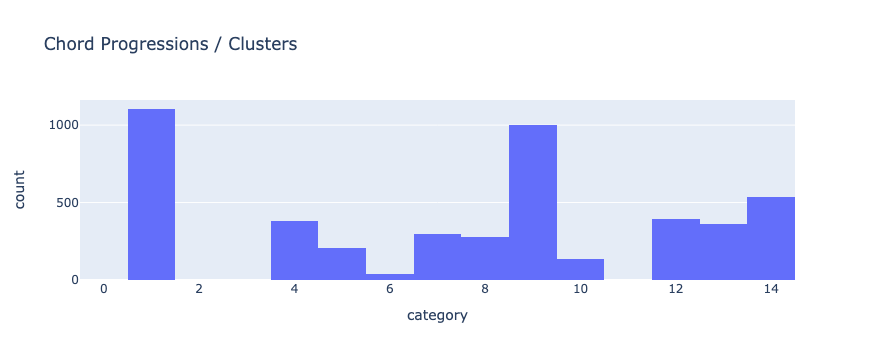

In [477]:
fig = px.histogram(chordsDF, x="category", title='Chord Progressions / Clusters')
fig.show()

### Doing some quick analysis

most popular chords among categories

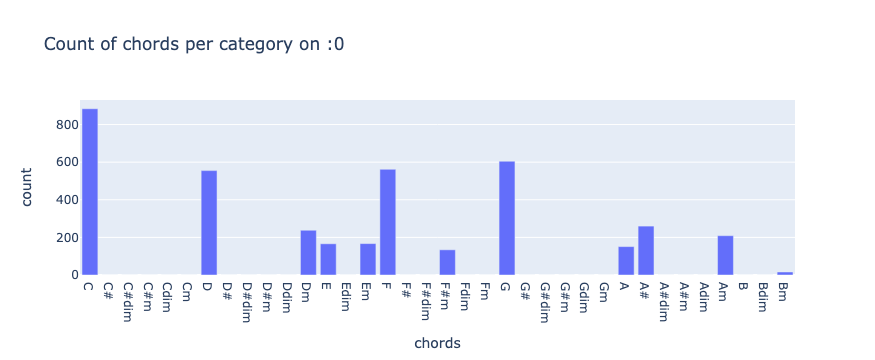

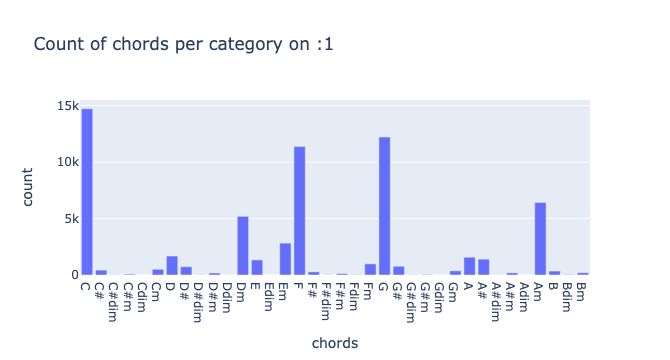

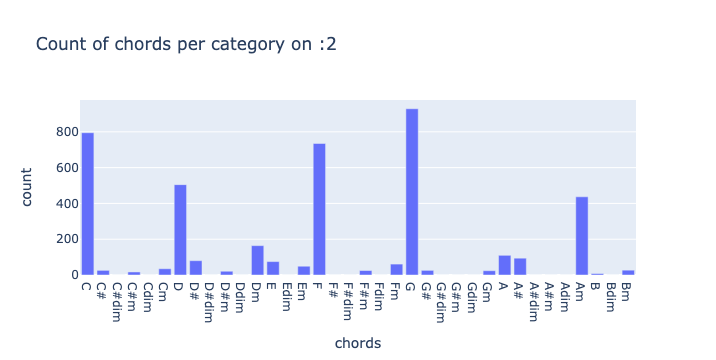

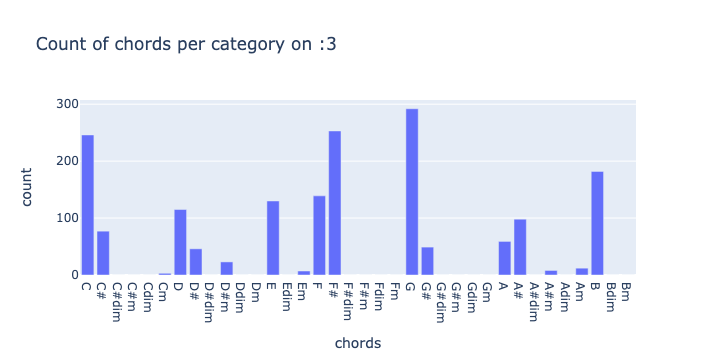

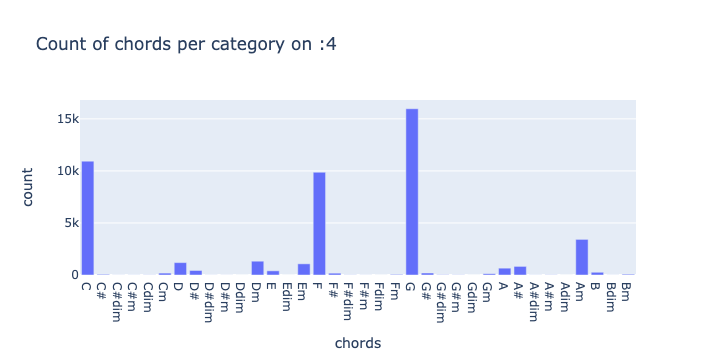

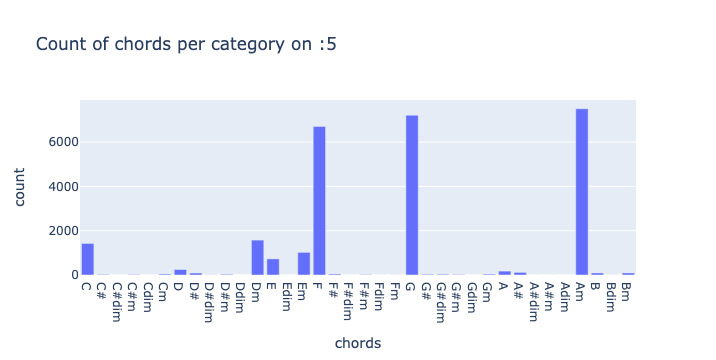

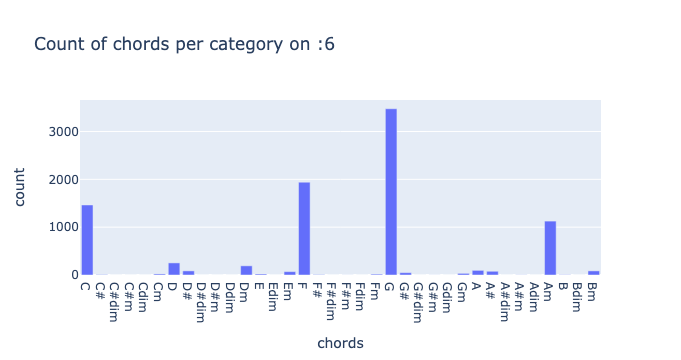

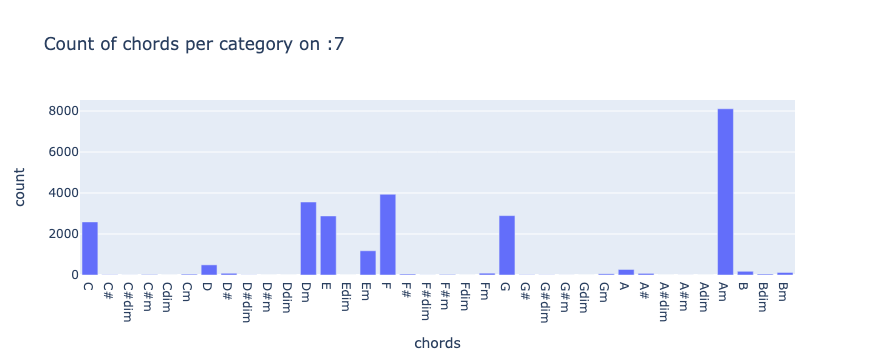

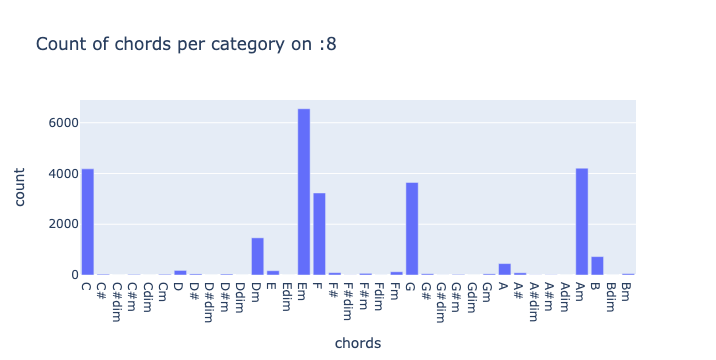

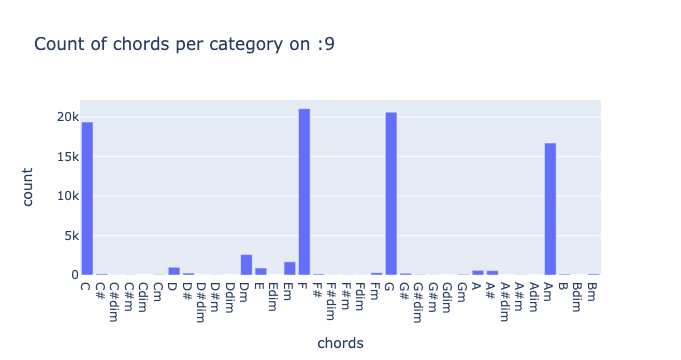

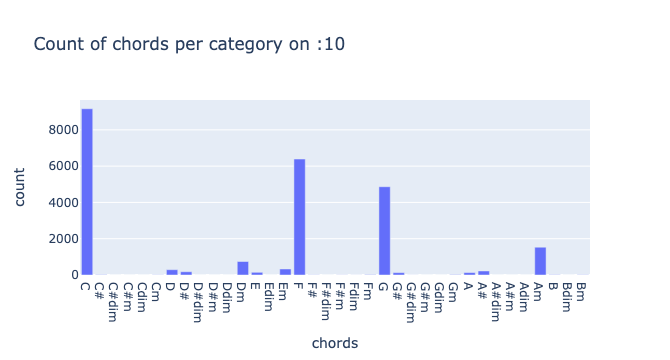

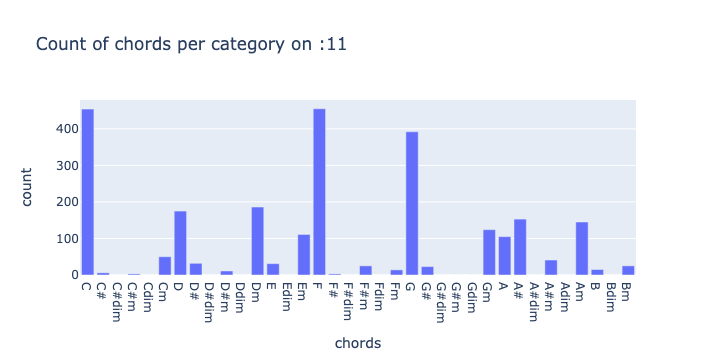

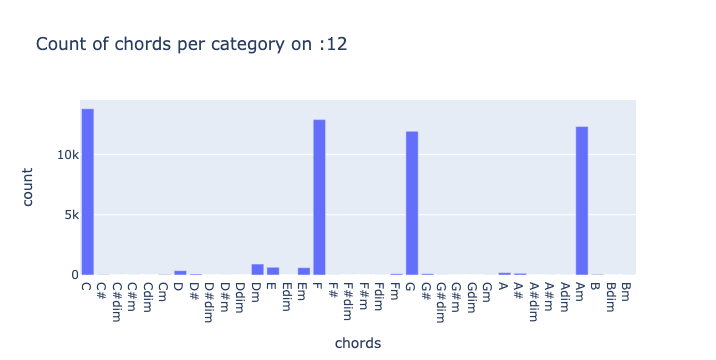

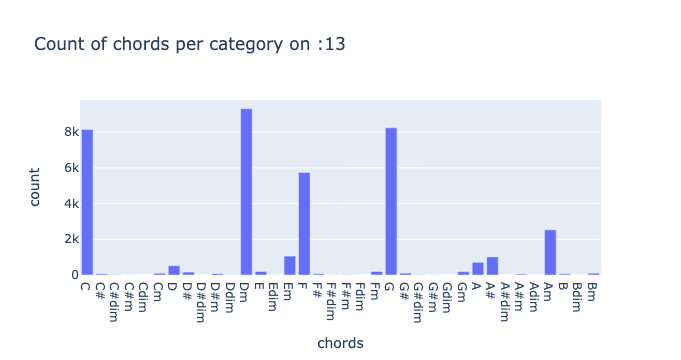

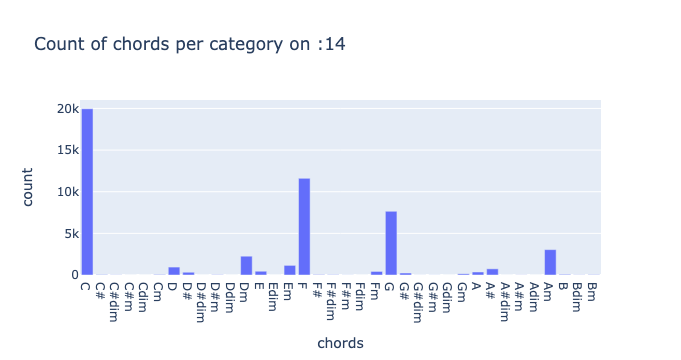

In [478]:
plotChordsPerCategory(numClusters)

### Ratio per chords and category


In [479]:
### Example , what's the ratio of the chord C per category
clusterChordsRatio, chordsRatio = getClustersChordsRatios(listKeys)

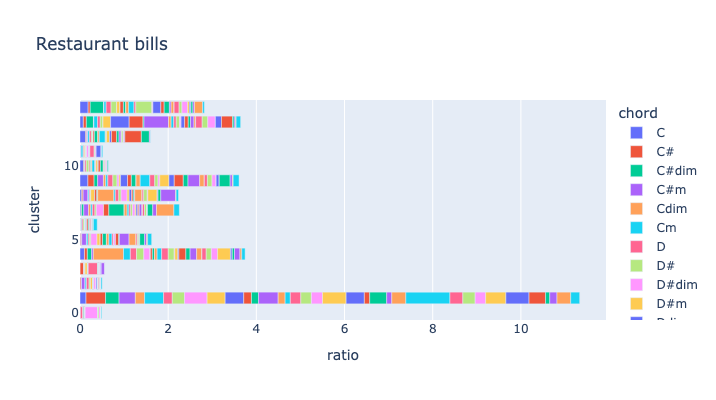

In [480]:
fig = px.bar(clusterChordsRatio, x="ratio", y="cluster", color='chord', orientation='h',
             height=400,
             title='Restaurant bills')
fig.show()

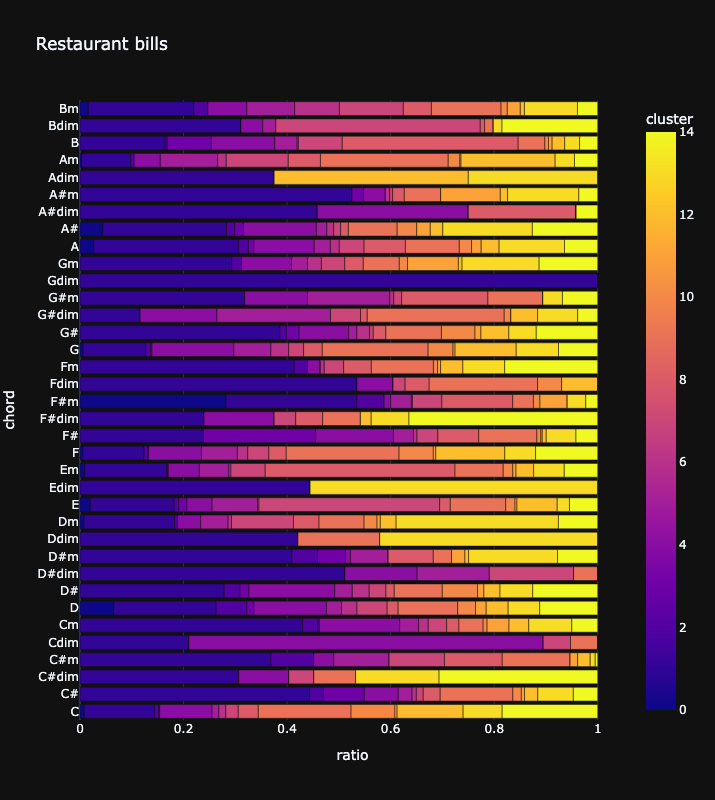

In [481]:
fig = px.bar(clusterChordsRatio, x="ratio", y="chord", color='cluster', orientation='h',
             height=800,
             template='plotly_dark',
             title='Restaurant bills')
fig.show()

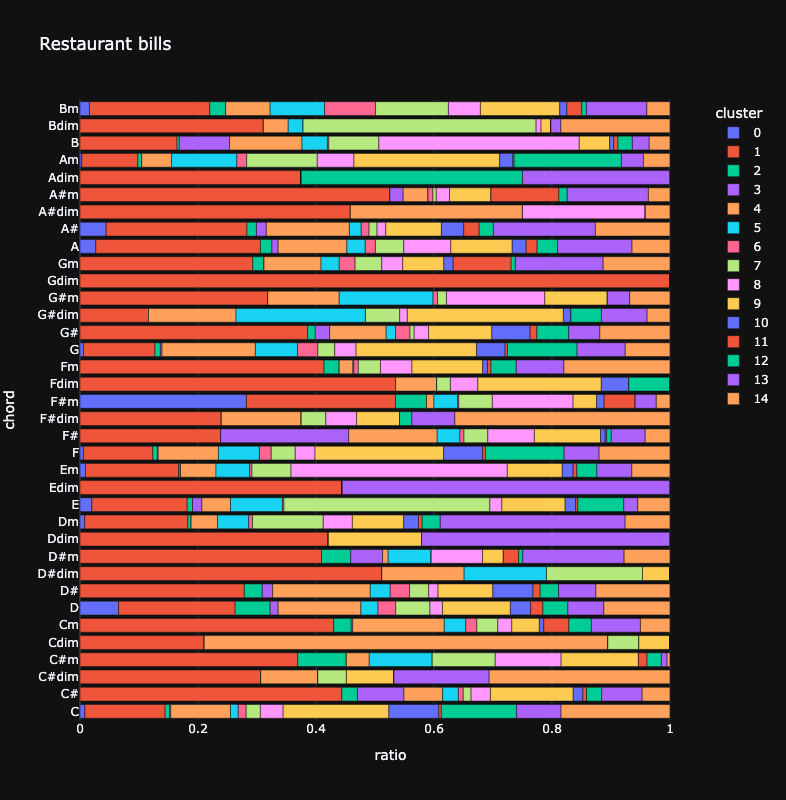

In [482]:
clusterChordsRatio['cluster'] = clusterChordsRatio['cluster'].astype(str)
fig = px.bar(clusterChordsRatio, x="ratio", y="chord", color='cluster', orientation='h',
             height=800,
             template='plotly_dark',
             title='Restaurant bills')
fig.show()

## Using Euclidean distance to make recommendations

### what songs are close to coldplay's don't panic

In [511]:


# df[df['song']=='Dont Panic'] ---- 163

coldplaySong = chordsDF.filter(items = [163], axis=0).iloc[:,0:-1].values.tolist()[0]
closest_clusters(coldplaySong)

[(10, 0.4116053949613803),
 (6, 0.47043322361816636),
 (12, 0.478586741255917),
 (2, 0.49791451176831864),
 (11, 0.5137852277562857),
 (5, 0.5232989753086791),
 (3, 0.5517588488324034),
 (0, 0.5628589972618132),
 (9, 0.6092232978545252),
 (14, 0.7038972353533323),
 (7, 0.7107148621565298),
 (8, 0.7416296592520742),
 (13, 0.9626552693589769),
 (4, 0.9740014788112132),
 (1, 2.149682562142517)]

In [520]:
chordsDF[chordsDF['category'] == 10]


,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,D#m,...,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm,category
15,76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,10
19,54,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,15,0,0,0,10
29,43,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,10
43,156,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,10
51,66,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,25,0,0,0,10
4376,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,14,0,0,0,10
4487,58,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20,0,0,0,10
4555,52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,0,0,0,10


,id,song,artist,tonality,capo,orig_key,chords
19,816,Beautiful Day,U2,,0,D,"G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,..."


In [526]:
df.filter(items = [19], axis=0)

,id,song,artist,tonality,capo,orig_key,chords
19,816,Beautiful Day,U2,,0,D,"G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,..."


In [528]:
u2beautiful = chordsDF.filter(items = [19], axis=0).iloc[:,0:-1].values.tolist()[0]

In [529]:
getRatioChordsSong(u2beautiful)

[0.32727272727272727,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.024242424242424242,
 0.0,
 0.0,
 0.024242424242424242,
 0.18181818181818182,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.30303030303030304,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.048484848484848485,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09090909090909091,
 0.0,
 0.0,
 0.0]

In [531]:
getRatioChordsSong(coldplaySong)

[0.21739130434782608,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13043478260869565,
 0.0,
 0.0,
 0.0,
 0.30434782608695654,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06521739130434782,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2826086956521739,
 0.0,
 0.0,
 0.0]